# 3D Classical Segmentation Pipeline with Quantitative Metrics

Este notebook executa segmentação clássica 3D (Otsu, Watershed, K-means, morfologia) em MRI pré-processados e calcula métricas quantitativas (Dice, Jaccard) em relação ao ground truth.


In [16]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.morphology import remove_small_objects, binary_opening, disk, ball, local_maxima
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter
from scipy import ndimage as ndi
from pathlib import Path
from sklearn.metrics import jaccard_score


## Funções de Métricas Quantitativas


In [17]:
def dice_coefficient(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    return 2. * intersection / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) > 0 else np.nan

def jaccard_index(mask1, mask2):
    mask1 = mask1.astype(bool).ravel()
    mask2 = mask2.astype(bool).ravel()
    return jaccard_score(mask1, mask2)


## Exemplo 3D: Segmentação Completa e Métricas


Shape after squeeze: (256, 256, 128)


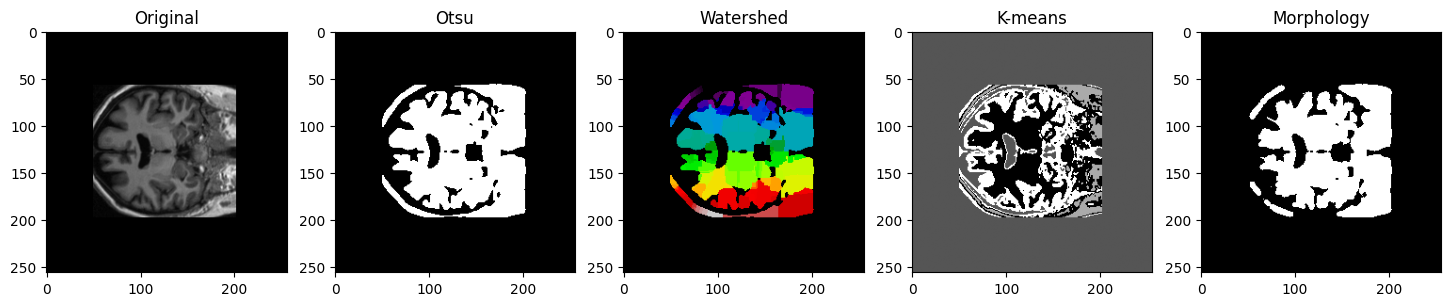

Otsu: Dice=0.604, Jaccard=0.433
Watershed: Dice=0.000, Jaccard=0.000
K-means: Dice=0.487, Jaccard=0.322
Morphology: Dice=0.587, Jaccard=0.416


In [18]:
img_path = Path('../data/preprocessed/IBSR_10_zscore.nii.gz')
gt_path = Path('../data/subset/IBSR_10/segmentation/analyze/IBSR_10_seg_ana.img')  
img = nib.load(str(img_path))
data = img.get_fdata()

data_smooth = gaussian_filter(data, sigma=1)

# Otsu 3D
otsu_thresh = threshold_otsu(data_smooth)
otsu_mask = data_smooth > otsu_thresh

# Watershed 3D
distance = ndi.distance_transform_edt(otsu_mask)
seed_mask = local_maxima(distance)
markers = ndi.label(seed_mask)[0]
labels_ws = watershed(-distance, markers, mask=otsu_mask)

# distance = ndi.distance_transform_edt(otsu_mask)
# footprint = np.ones([3] * distance.ndim)
# local_maxi = peak_local_max(distance, labels=otsu_mask, footprint=footprint, exclude_border=False)
# local_maxi_mask = np.zeros_like(distance, dtype=bool)
# local_maxi_mask[tuple(local_maxi.T)] = True
# markers = ndi.label(local_maxi_mask)[0]
# labels_ws = watershed(-distance, markers, mask=otsu_mask)

# K-means 3D
X = data.reshape(-1, 1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
kmeans_mask = kmeans.labels_.reshape(data.shape)

# Morfologia 3D
morph_mask = remove_small_objects(otsu_mask, min_size=100)
morph_mask = np.squeeze(morph_mask)
print("Shape after squeeze:", morph_mask.shape)

if morph_mask.ndim == 2:
    selem = disk(3)
elif morph_mask.ndim == 3:
    selem = ball(3)
else:
    raise ValueError(f"Unsupported mask dimension: {morph_mask.ndim}")

# Só aplica se as dimensões baterem
if morph_mask.ndim == selem.ndim:
    morph_mask = binary_opening(morph_mask, selem)
else:
    print(f"Skipping morphology: mask shape {morph_mask.shape}, selem shape {selem.shape}")

# Visualização de slices
slice_idx = data.shape[2] // 2
plt.figure(figsize=(18,6))
plt.subplot(1,5,1); plt.imshow(data[:,:,slice_idx], cmap='gray'); plt.title('Original')
plt.subplot(1,5,2); plt.imshow(otsu_mask[:,:,slice_idx], cmap='gray'); plt.title('Otsu')
plt.subplot(1,5,3); plt.imshow(labels_ws[:,:,slice_idx], cmap='nipy_spectral'); plt.title('Watershed')
plt.subplot(1,5,4); plt.imshow(kmeans_mask[:,:,slice_idx], cmap='gray'); plt.title('K-means')
plt.subplot(1,5,5); plt.imshow(morph_mask[:,:,slice_idx], cmap='gray'); plt.title('Morphology')
plt.show()

# Salvar máscaras
out_dir = Path('../data/classical_segmented')
out_dir.mkdir(exist_ok=True)
nib.save(nib.Nifti1Image(otsu_mask.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_otsu.nii.gz')
nib.save(nib.Nifti1Image(labels_ws.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_watershed.nii.gz')
nib.save(nib.Nifti1Image(kmeans_mask.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_kmeans.nii.gz')
nib.save(nib.Nifti1Image(morph_mask.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_morph.nii.gz')
# Métricas quantitativas
if gt_path.exists():
    gt_img = nib.load(str(gt_path))
    gt_data = gt_img.get_fdata()
    gt_bin = (gt_data > 0)
    metrics = {}
    for name, mask in zip([
        'Otsu', 'Watershed', 'K-means', 'Morphology'],
        [otsu_mask, labels_ws, kmeans_mask, morph_mask]
    ):
        # Para watershed e kmeans, pode ser necessário binarizar...
        if name in ['Watershed', 'K-means']:
            mask_bin = (mask == mask.max()) if mask.max() > 1 else (mask > 0)
        else:
            mask_bin = mask > 0
        mask_bin = np.squeeze(mask_bin)
        gt_bin = np.squeeze(gt_bin)
        dice = dice_coefficient(mask_bin, gt_bin)
        jaccard = jaccard_index(mask_bin, gt_bin)
        metrics[name] = {'Dice': dice, 'Jaccard': jaccard}
        print(f'{name}: Dice={dice:.3f}, Jaccard={jaccard:.3f}')
    df_metrics = pd.DataFrame(metrics).T
    df_metrics.to_csv(out_dir / f'IBSR_10_metrics.csv')
else:
    print('Ground truth not found, skipping metrics.')


## Processamento em Lote


In [21]:
input_dir = Path('../data/preprocessed')
gt_dir = Path('../data/subset')
out_dir = Path('../data/classical_segmented')
out_dir.mkdir(exist_ok=True)
results = []
for img_path in input_dir.glob('*_zscore.nii.gz'):
    subject = '_'.join(img_path.stem.split('_')[:2])
    img = nib.load(str(img_path))
    data = img.get_fdata()
    data_smooth = gaussian_filter(data, sigma=1)
    # Otsu 3D
    otsu_thresh = threshold_otsu(data_smooth)
    otsu_mask = data_smooth > otsu_thresh
    # Watershed 3D
    distance = ndi.distance_transform_edt(otsu_mask)
    seed_mask = local_maxima(distance)
    markers = ndi.label(seed_mask)[0]
    labels_ws = watershed(-distance, markers, mask=otsu_mask)
    # K-means 3D
    X = data.reshape(-1, 1)
    kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
    kmeans_mask = kmeans.labels_.reshape(data.shape)
    # Morfologia 3D
    morph_mask = remove_small_objects(otsu_mask, min_size=100)
    morph_mask = np.squeeze(morph_mask)
    print("Shape after squeeze:", morph_mask.shape)

    if morph_mask.ndim == 2:
        selem = disk(3)
    elif morph_mask.ndim == 3:
        selem = ball(3)
    else:
        raise ValueError(f"Unsupported mask dimension: {morph_mask.ndim}")

    # Só aplica se as dimensões baterem
    if morph_mask.ndim == selem.ndim:
        morph_mask = binary_opening(morph_mask, selem)
    else:
        print(f"Skipping morphology: mask shape {morph_mask.shape}, selem shape {selem.shape}")
    # Salvar
    nib.save(nib.Nifti1Image(otsu_mask.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_otsu.nii.gz')
    nib.save(nib.Nifti1Image(labels_ws.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_watershed.nii.gz')
    nib.save(nib.Nifti1Image(kmeans_mask.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_kmeans.nii.gz')
    nib.save(nib.Nifti1Image(morph_mask.astype(np.uint8), img.affine), out_dir / f'{img_path.stem}_morph.nii.gz')
    # Métricas
    gt_path = gt_dir / subject / 'segmentation/analyze' / f'{subject}_seg_ana.img'
    if gt_path.exists():
        gt_img = nib.load(str(gt_path))
        gt_data = gt_img.get_fdata()
        gt_bin = (gt_data > 0)
        for name, mask in zip([
            'Otsu', 'Watershed', 'K-means', 'Morphology'],
            [otsu_mask, labels_ws, kmeans_mask, morph_mask]
        ):
            if name in ['Watershed', 'K-means']:
                mask_bin = (mask == mask.max()) if mask.max() > 1 else (mask > 0)
            else:
                mask_bin = mask > 0
            mask_bin = np.squeeze(mask_bin)
            gt_bin = np.squeeze(gt_bin)
            dice = dice_coefficient(mask_bin, gt_bin)
            jaccard = jaccard_index(mask_bin, gt_bin)
            results.append({'subject': subject, 'dice_otsu': dice, 'jaccard_otsu': jaccard})
            print(f'{name}: Dice={dice:.3f}, Jaccard={jaccard:.3f}')
    else:
        results.append({'subject': subject, 'dice_otsu': np.nan, 'jaccard_otsu': np.nan})
    print(f'Segmentação e métricas para {subject} concluídas.')
    df = pd.DataFrame(results)
    display(df)
    df.to_csv(out_dir / 'segmentation_metrics.csv', index=False)


Shape after squeeze: (256, 256, 128)
Otsu: Dice=0.793, Jaccard=0.657
Watershed: Dice=0.000, Jaccard=0.000
K-means: Dice=0.000, Jaccard=0.000
Morphology: Dice=0.838, Jaccard=0.721
Segmentação e métricas para IBSR_04 concluídas.


,subject,dice_otsu,jaccard_otsu
0,IBSR_04,0.792947,0.656928
1,IBSR_04,0.000000,0.000000
2,IBSR_04,0.000179,0.000089
3,IBSR_04,0.837726,0.720764


Shape after squeeze: (256, 256, 128)
Otsu: Dice=0.604, Jaccard=0.433
Watershed: Dice=0.000, Jaccard=0.000
K-means: Dice=0.487, Jaccard=0.322
Morphology: Dice=0.587, Jaccard=0.416
Segmentação e métricas para IBSR_10 concluídas.


,subject,dice_otsu,jaccard_otsu
0,IBSR_04,0.792947,0.656928
1,IBSR_04,0.000000,0.000000
2,IBSR_04,0.000179,0.000089
3,IBSR_04,0.837726,0.720764
4,IBSR_10,0.604029,0.432695
5,IBSR_10,0.000000,0.000000
6,IBSR_10,0.486655,0.321575
7,IBSR_10,0.587073,0.415502


Shape after squeeze: (256, 256, 128)
Otsu: Dice=0.699, Jaccard=0.538
Watershed: Dice=0.000, Jaccard=0.000
K-means: Dice=0.096, Jaccard=0.050
Morphology: Dice=0.721, Jaccard=0.563
Segmentação e métricas para IBSR_02 concluídas.


,subject,dice_otsu,jaccard_otsu
0,IBSR_04,0.792947,0.656928
1,IBSR_04,0.000000,0.000000
2,IBSR_04,0.000179,0.000089
3,IBSR_04,0.837726,0.720764
4,IBSR_10,0.604029,0.432695
5,IBSR_10,0.000000,0.000000
6,IBSR_10,0.486655,0.321575
7,IBSR_10,0.587073,0.415502
8,IBSR_02,0.699379,0.537727
9,IBSR_02,0.000000,0.000000


Shape after squeeze: (256, 256, 128)
Otsu: Dice=0.758, Jaccard=0.611
Watershed: Dice=0.000, Jaccard=0.000
K-means: Dice=0.000, Jaccard=0.000
Morphology: Dice=0.797, Jaccard=0.662
Segmentação e métricas para IBSR_03 concluídas.


,subject,dice_otsu,jaccard_otsu
0,IBSR_04,0.792947,0.656928
1,IBSR_04,0.000000,0.000000
2,IBSR_04,0.000179,0.000089
3,IBSR_04,0.837726,0.720764
4,IBSR_10,0.604029,0.432695
5,IBSR_10,0.000000,0.000000
6,IBSR_10,0.486655,0.321575
7,IBSR_10,0.587073,0.415502
8,IBSR_02,0.699379,0.537727
9,IBSR_02,0.000000,0.000000
